### Sequence humanization

This notebook evaluates how well the default humanization routine (```suggest_mutations```) in AntPack
works compared with the Sapiens and Hu-mAb alternatives from the literature. Humanization is a tradeoff
between making the sequence as human as possible and preserving as much of the original sequence as
possible (the more changes, the more likely loss of affinity). Most humanization efforts leave the CDRs
unchanged; some also opt to preserve so-called Vernier zones, framework regions thought to be involved
in CDR loop region structure.

In this experiment, we show how setting the s_thresh parameter in AntPack to different values can achieve
either higher humanness or higher preservation depending on priorities. It's also possible to do "manual" humanization
using AntPack -- see the AntPack docs for a tutorial; this experiment considers the automated procedure only.

In [1]:
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from antpack import SingleChainAnnotator, SequenceScoringTool, HumanizationTool

aligner = SingleChainAnnotator(chains=["H", "K", "L"], scheme = "imgt")

if "notebooks" in os.getcwd():
    current_dir = os.path.join(os.getcwd(), "..", "..")

humanization_tool = HumanizationTool()
score_tool = SequenceScoringTool()
annotator = SingleChainAnnotator()

os.chdir(current_dir)
    
if "humanization_test_data" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "humanization_test_data"))

In [2]:
paired_seq_dict = {}

target_files = ["parental", "experimental", "sapiens1", "sapiens2", "sapiens3", "sapiens4", "sapiens5",
               "straight_grafts", "vernier_grafts", "humab"]

for seqtype in target_files:
    with open(f"{seqtype}.fa", "r") as fh:
        for seqrec in SeqIO.parse(fh, "fasta"):
            seqname = seqrec.description.split()[0]
            chain = seqrec.description.split()[1]
            if seqname not in paired_seq_dict:
                paired_seq_dict[seqname] = {}
                for key in target_files:
                    paired_seq_dict[seqname][f"{key}_VH"] = None
                    paired_seq_dict[seqname][f"{key}_VL"] = None

            key = f"{seqtype}_{chain}"
            if paired_seq_dict[seqname][key] is not None:
                raise ValueError(f"Duplication on {key}")
            paired_seq_dict[seqname][key] = str(seqrec.seq)

Let's define some key residues that should not be modified. These are from Villani et al.2008 and
Donini et al. 2003, where these were shown to be sufficient to preserve affinity. Let's also keep
track of the Vernier zone residues from Foote and Winter 1992. We're not going to force these to
be preserved, but we can see how much of them is modified by different approaches.

In [3]:
light_key_resid = ['35', '87', '106', '111']
heavy_key_resid = ['30', '80', '106', '116']

light_vernier = {'2', '4', '41', '42', '52', '53', '54', '55', '78', '80', '82', '83', '84', '85', '87', '118'}
heavy_vernier = {'2', '28', '29', '30', '31', '52', '53', '54', '76', '78', '80', '82', '87', '105', '106', '118'}

After loading the humanization results for other tools, we'll humanize all 25 sequences in this
dataset using AntPack and store preservation, overlap and humanness scores.

In [4]:
def humanize_seq(s_thresh, parental_h, parental_l, heavy_excluded, light_excluded,
                      h_exp_muts, l_exp_muts, scoring_tool):
    hscore, hmuts, uvh = humanization_tool.suggest_mutations(parental_h, s_thresh = s_thresh,
                                                             excluded_positions = heavy_excluded)
    lscore, lmuts, uvl = humanization_tool.suggest_mutations(parental_l, s_thresh = s_thresh,
                                                             excluded_positions = light_excluded)
    
    return get_key_statistics(parental_h, parental_l, uvh, uvl, h_exp_muts,
                              l_exp_muts, scoring_tool)



def get_key_statistics(parental_h, parental_l, modified_h, modified_l,
                       h_exp_muts, l_exp_muts, scoring_tool):
    h_numbering = scoring_tool.aligner.analyze_seq(parental_h)[0]
    l_numbering = scoring_tool.aligner.analyze_seq(parental_l)[0]

    hmuts = [f"{p}_{str(i+1)}_{m}" for i, (p,m) in enumerate(zip(parental_h, modified_h)) if m != p]
    lmuts = [f"{p}_{str(i+1)}_{m}" for i, (p,m) in enumerate(zip(parental_l, modified_l)) if m != p]
    imgt_hmuts = [himgt for (p,m,himgt) in zip(parental_h, modified_h, h_numbering) if m != p]
    imgt_lmuts = [limgt for (p,m,limgt) in zip(parental_l, modified_l, l_numbering) if m != p]

    overlap = len([m for m in hmuts if m in h_exp_muts]) + \
            len([m for m in lmuts if m in l_exp_muts])

    nmutations = len(hmuts) + len(lmuts)
    preservation = 1 - nmutations / (len(parental_h) + len(parental_l))

    score = np.mean([scoring_tool.score_seqs([modified_h]), score_tool.score_seqs([modified_l])])
    overlap = overlap / max(nmutations, 1)

    vernier_pres = len([h for h in imgt_hmuts if h in heavy_vernier]) + \
            len([l for l in imgt_lmuts if l in light_vernier])
    vernier_pres = 1 - vernier_pres / (len(heavy_vernier) + len(light_vernier))
    
    key_resid_pres = len([h for h in imgt_hmuts if h in heavy_key_resid]) + \
            len([l for l in imgt_lmuts if l in light_key_resid])
    key_resid_pres = 1 - key_resid_pres / (len(heavy_key_resid) + len(light_key_resid))
    
    return preservation, score, overlap, vernier_pres, key_resid_pres

In [5]:
score_progress_dict = {"Name":[]}

for key in target_files + ["SAM_125_percent", "SAM_straight_graft", "SAM_110_percent"]:
    score_progress_dict[f"{key}_score"] = []
    score_progress_dict[f"{key}_preservation"] = []
    score_progress_dict[f"{key}_overlap"] = []
    score_progress_dict[f"{key}_vernier_preservation"] = []
    score_progress_dict[f"{key}_key_residue_preservation"] = []

for name in paired_seq_dict:
    seq_group = paired_seq_dict[name]
    pvh, pvl, evh, evl = seq_group["parental_VH"], seq_group["parental_VL"], seq_group["experimental_VH"], \
        seq_group["experimental_VL"]

    light_exp_mutations = set( [f"{pvl[j]}_{j+1}_{evl[j]}" for j in range(len(pvl)) if pvl[j] != evl[j] ] )
    heavy_exp_mutations = set( [f"{pvh[j]}_{j+1}_{evh[j]}" for j in range(len(pvh)) if pvh[j] != evh[j] ] )

    score_progress_dict["Name"].append(name)

    parental_score = np.mean( [score_tool.score_seqs([pvh]), score_tool.score_seqs([pvl])] )
    exp_score = np.mean( [score_tool.score_seqs([seq_group["experimental_VH"]]),
                          score_tool.score_seqs([seq_group["experimental_VL"]])] )

    for seqtype in target_files:
        preservation, score, overlap, vernier_pres, key_resid_pres = get_key_statistics(pvh, pvl, seq_group[f"{seqtype}_VH"],
                        seq_group[f"{seqtype}_VL"], heavy_exp_mutations, light_exp_mutations,
                                                          score_tool)
        score_progress_dict[f"{seqtype}_score"].append(score - parental_score)
        score_progress_dict[f"{seqtype}_preservation"].append( preservation )
        score_progress_dict[f"{seqtype}_overlap"].append( overlap )
        score_progress_dict[f"{seqtype}_vernier_preservation"].append( vernier_pres )
        score_progress_dict[f"{seqtype}_key_residue_preservation"].append( key_resid_pres )

    for s_thresh in [0.99, 1.1, 1.25]:
        if s_thresh == 0.99:
            text_name = "straight_graft"
            preservation, score, overlap, vernier_pres, key_resid_pres = humanize_seq(s_thresh, pvh, pvl, [], [],
                      heavy_exp_mutations, light_exp_mutations, score_tool)
        else:
            text_name = str(int(s_thresh * 100)) + "_percent"
            preservation, score, overlap, vernier_pres, key_resid_pres = humanize_seq(s_thresh, pvh, pvl, heavy_key_resid, light_key_resid,
                      heavy_exp_mutations, light_exp_mutations, score_tool)

        score_progress_dict[f"SAM_{text_name}_preservation"].append( preservation )
        score_progress_dict[f"SAM_{text_name}_score"].append(score - parental_score)
        score_progress_dict[f"SAM_{text_name}_overlap"].append( overlap )
        score_progress_dict[f"SAM_{text_name}_vernier_preservation"].append( vernier_pres )
        score_progress_dict[f"SAM_{text_name}_key_residue_preservation"].append( key_resid_pres )
    
    print(f"Name {name} complete.")


score_progress = pd.DataFrame.from_dict(score_progress_dict)

Name AntiCD28 complete.
Name Campath complete.
Name Bevacizumab complete.
Name Herceptin complete.
Name Omalizumab complete.
Name Eculizumab complete.
Name Tocilizumab complete.
Name Pembrolizumab complete.
Name Pertuzumab complete.
Name Ixekizumab complete.
Name Palivizumab complete.
Name Certolizumab complete.
Name Idarucizumab complete.
Name Reslizumab complete.
Name Solanezumab complete.
Name Lorvotuzumab complete.
Name Pinatuzumab complete.
Name Etaracizumab complete.
Name Talacotuzumab complete.
Name Rovalpituzumab complete.
Name Clazakizumab complete.
Name Ligelizumab complete.
Name Crizanlizumab complete.
Name Mogamulizumab complete.
Name Refanezumab complete.


In [6]:
plotting_dict = {"score":{}, "preservation":{}, "vernier_preservation":{},
                 "key_residue_preservation":{}, "overlap":{} }

for key in plotting_dict:
    cols = [f"{seqtype}_{key}" for seqtype in target_files[1:]] + [f"SAM_{cat}_{key}" for cat in ["125_percent",
                        "110_percent", "straight_graft"]]
    subset = score_progress[cols]
    plotting_dict[key]["list"] = np.concatenate([score_progress[col].values for col in cols])
    plotting_dict[key]["labels"] = np.concatenate([np.full(score_progress.shape[0], c) for c in cols])
    plotting_dict[key]["cols"] = cols

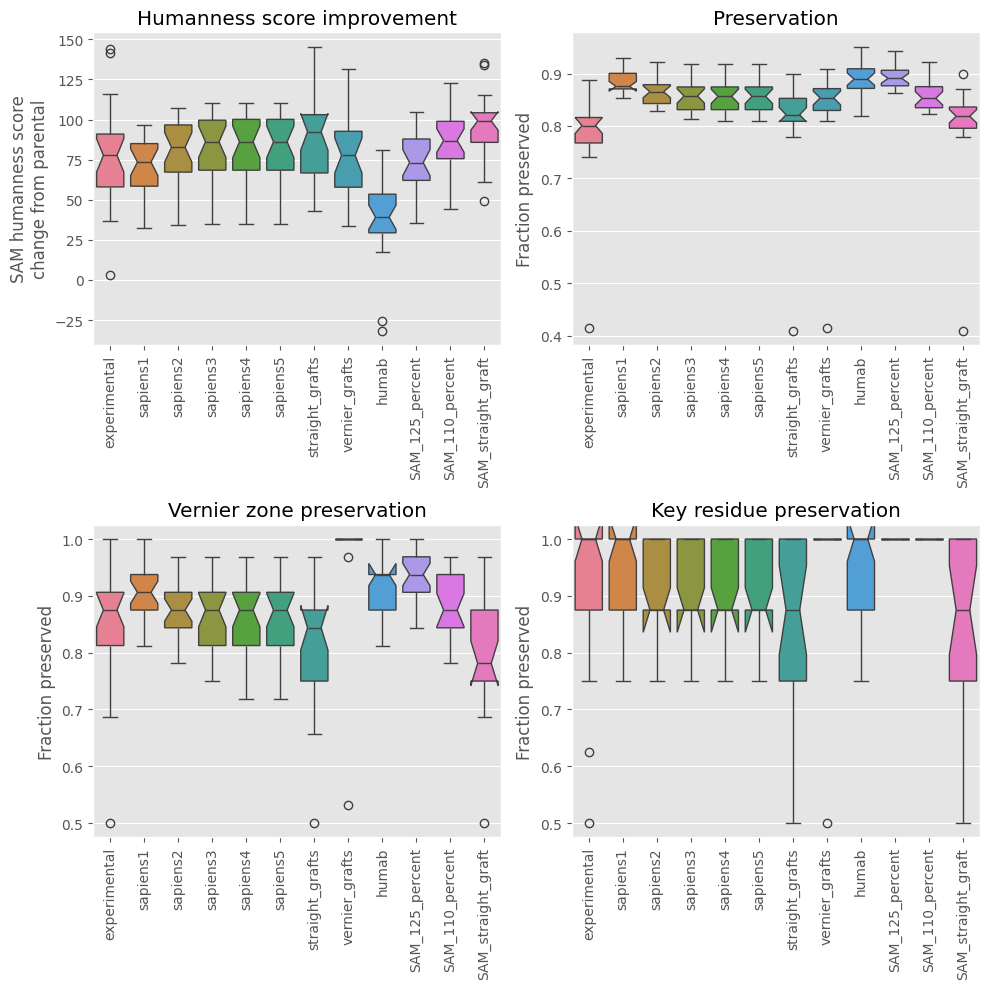

In [7]:
plt.style.use("ggplot")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))

axes = [ax1, ax2, ax3, ax4]

for key, ax in zip(["score", "preservation", "vernier_preservation", "key_residue_preservation"], axes):
    subdict = plotting_dict[key]
    sns.boxplot(x=subdict['labels'], y=subdict['list'], hue=subdict['labels'], notch=True, ax=ax)
    ax.set_xticks(np.arange(len(subdict['cols'])), [s.split(f"_{key}")[0] for s in subdict['cols']], rotation=90)

ax1.set_title("Humanness score improvement")
ax2.set_title("Preservation")
ax1.set_ylabel("SAM humanness score\nchange from parental")
ax2.set_ylabel("Fraction preserved")
ax3.set_title("Vernier zone preservation")
ax3.set_ylabel("Fraction preserved")
ax4.set_title("Key residue preservation")
ax4.set_ylabel("Fraction preserved")
plt.tight_layout()
#plt.savefig("humanness_experiment.png")
plt.show()

In [8]:
os.getcwd()

'/ssd1/Documents/Wang_Lab_Projects/immunogenicity/humanness_evaluation/humanization_test_data'

In [9]:
import scipy
from scipy import stats

for s in plotting_dict["preservation"]['cols']:
    data = score_progress[s].values
    m = data.mean()
    h = stats.sem(data) * scipy.stats.t.ppf(1.95 / 2., data.shape[0] - 1)
    print(f"{s}:\t\t{m}\tLCB:{m-h}\tUCB:{m+h}")

experimental_preservation:		0.7877709023721938	LCB:0.751134128609996	UCB:0.8244076761343917
sapiens1_preservation:		0.8848406070090978	LCB:0.8765425829084643	UCB:0.8931386311097314
sapiens2_preservation:		0.8639708785194375	LCB:0.8535736465414089	UCB:0.8743681104974662
sapiens3_preservation:		0.8572900684457636	LCB:0.8457761549117052	UCB:0.868803981979822
sapiens4_preservation:		0.8558778880154544	LCB:0.8436948941249233	UCB:0.8680608819059855
sapiens5_preservation:		0.8558778880154544	LCB:0.8436948941249233	UCB:0.8680608819059855
straight_grafts_preservation:		0.8122970061019416	LCB:0.7755651354603361	UCB:0.849028876743547
vernier_grafts_preservation:		0.8374280595753594	LCB:0.799467525270013	UCB:0.8753885938807058
humab_preservation:		0.8895543741251224	LCB:0.8758339867126405	UCB:0.9032747615376043
SAM_125_percent_preservation:		0.8934875578930165	LCB:0.8840946423404085	UCB:0.9028804734456245
SAM_110_percent_preservation:		0.8576862621973081	LCB:0.8470300614270693	UCB:0.86834246296754

In [10]:
import scipy
from scipy import stats

for s in plotting_dict["score"]['cols']:
    data = score_progress[s].values
    m = data.mean()
    h = stats.sem(data) * scipy.stats.t.ppf(1.95 / 2., data.shape[0] - 1)
    print(f"{s}:\t\t{m}\tLCB:{m-h}\tUCB:{m+h}")

experimental_score:		77.12190220925733	LCB:64.09748084921107	UCB:90.14632356930359
sapiens1_score:		71.12155938132602	LCB:64.04177545533253	UCB:78.20134330731952
sapiens2_score:		79.02968337967923	LCB:71.18057025818425	UCB:86.87879650117421
sapiens3_score:		81.5694384899221	LCB:73.38722362100549	UCB:89.75165335883872
sapiens4_score:		82.09963742711432	LCB:73.7121487017401	UCB:90.48712615248853
sapiens5_score:		82.09963742711432	LCB:73.7121487017401	UCB:90.48712615248853
straight_grafts_score:		87.83864746302656	LCB:77.72876708273259	UCB:97.94852784332053
vernier_grafts_score:		75.41857840822463	LCB:65.68760199209336	UCB:85.1495548243559
humab_score:		37.96286908904452	LCB:27.326175117222512	UCB:48.59956306086652
SAM_125_percent_score:		73.36253826406666	LCB:65.7658855142767	UCB:80.95919101385661
SAM_110_percent_score:		86.02639074023226	LCB:78.05424615788357	UCB:93.99853532258095
SAM_straight_graft_score:		95.16344625643825	LCB:86.65304167989115	UCB:103.67385083298535


In [11]:
import scipy
from scipy import stats

for s in plotting_dict["vernier_preservation"]['cols']:
    data = score_progress[s].values
    m = data.mean()
    h = stats.sem(data) * scipy.stats.t.ppf(1.95 / 2., data.shape[0] - 1)
    print(f"{s}:\t\t{m}\tLCB:{m-h}\tUCB:{m+h}")

experimental_vernier_preservation:		0.8525	LCB:0.806663365399738	UCB:0.898336634600262
sapiens1_vernier_preservation:		0.905	LCB:0.884441793502357	UCB:0.9255582064976431
sapiens2_vernier_preservation:		0.88	LCB:0.8580710777827023	UCB:0.9019289222172977
sapiens3_vernier_preservation:		0.87125	LCB:0.8488085630090427	UCB:0.8936914369909572
sapiens4_vernier_preservation:		0.87	LCB:0.8462497483940796	UCB:0.8937502516059204
sapiens5_vernier_preservation:		0.87	LCB:0.8462497483940796	UCB:0.8937502516059204
straight_grafts_vernier_preservation:		0.80625	LCB:0.762190277193881	UCB:0.850309722806119
vernier_grafts_vernier_preservation:		0.98	LCB:0.9413234068880736	UCB:1.0186765931119264
humab_vernier_preservation:		0.915	LCB:0.8947681349618337	UCB:0.9352318650381664
SAM_125_percent_vernier_preservation:		0.92625	LCB:0.9105043171389092	UCB:0.9419956828610908
SAM_110_percent_vernier_preservation:		0.88375	LCB:0.8612468597389126	UCB:0.9062531402610875
SAM_straight_graft_vernier_preservation:		0.8012

In [12]:
for s in plotting_dict["overlap"]['cols']:
    data = score_progress[s].values
    m = data.mean()
    h = stats.sem(data) * scipy.stats.t.ppf(1.95 / 2., data.shape[0] - 1)
    print(f"{s}:\t\t{m}\tLCB:{m-h}\tUCB:{m+h}")

experimental_overlap:		1.0	LCB:1.0	UCB:1.0
sapiens1_overlap:		0.7616629838760274	LCB:0.6996258462683147	UCB:0.82370012148374
sapiens2_overlap:		0.7275455112379038	LCB:0.6642812581634889	UCB:0.7908097643123186
sapiens3_overlap:		0.7141909963165266	LCB:0.6469597743196788	UCB:0.7814222183133744
sapiens4_overlap:		0.7111781399548665	LCB:0.6427113446010057	UCB:0.7796449353087272
sapiens5_overlap:		0.7111781399548665	LCB:0.6427113446010057	UCB:0.7796449353087272
straight_grafts_overlap:		0.6501413776388795	LCB:0.5798705805946116	UCB:0.7204121746831473
vernier_grafts_overlap:		0.7005321436907466	LCB:0.6338608951194112	UCB:0.7672033922620819
humab_overlap:		0.6995824127955426	LCB:0.6583365904331374	UCB:0.7408282351579477
SAM_125_percent_overlap:		0.7600877145599552	LCB:0.6965605863156208	UCB:0.8236148428042895
SAM_110_percent_overlap:		0.7409750063721368	LCB:0.6776265746940615	UCB:0.804323438050212
SAM_straight_graft_overlap:		0.7165456575954269	LCB:0.6553480015207704	UCB:0.7777433136700833


In [13]:
for s in plotting_dict["key_residue_preservation"]['cols']:
    data = score_progress[s].values
    m = data.mean()
    h = stats.sem(data) * scipy.stats.t.ppf(1.95 / 2., data.shape[0] - 1)
    print(f"{s}:\t\t{m}\tLCB:{m-h}\tUCB:{m+h}")

experimental_key_residue_preservation:		0.91	LCB:0.8552321011340948	UCB:0.9647678988659053
sapiens1_key_residue_preservation:		0.925	LCB:0.8885150832847917	UCB:0.9614849167152084
sapiens2_key_residue_preservation:		0.91	LCB:0.8719669169382184	UCB:0.9480330830617817
sapiens3_key_residue_preservation:		0.9	LCB:0.860591785894288	UCB:0.9394082141057121
sapiens4_key_residue_preservation:		0.9	LCB:0.860591785894288	UCB:0.9394082141057121
sapiens5_key_residue_preservation:		0.9	LCB:0.860591785894288	UCB:0.9394082141057121
straight_grafts_key_residue_preservation:		0.85	LCB:0.7923122814691963	UCB:0.9076877185308037
vernier_grafts_key_residue_preservation:		0.98	LCB:0.9387220287674396	UCB:1.0212779712325604
humab_key_residue_preservation:		0.935	LCB:0.9047666451068013	UCB:0.9652333548931988
SAM_125_percent_key_residue_preservation:		1.0	LCB:1.0	UCB:1.0
SAM_110_percent_key_residue_preservation:		1.0	LCB:1.0	UCB:1.0
SAM_straight_graft_key_residue_preservation:		0.86	LCB:0.8056386984341909	UCB:0.9